In [1]:
import ctypes
from ctypes.util import find_library

def unload_lib(lib):
    """Unload the loaded CDLL library from memory."""
    if not hasattr(lib, "_handle"):
        raise ValueError("Object is not a loaded CDLL library.")
    
    # Ищем libdl
    libdl_path = find_library("dl")
    if not libdl_path:
        raise RuntimeError("libdl not found — unloading .so is not possible.")
    
    libdl = ctypes.CDLL(libdl_path)

    dlclose = libdl.dlclose
    dlclose.argtypes = [ctypes.c_void_p]
    dlclose.restype = ctypes.c_int

    handle = lib._handle
    ret = dlclose(handle)

    if ret == 0:
        print(f"✅ Library {lib._name} unloaded from memory.")
        return True
    else:
        # you can call ctypes.get_errno(), but dlclose does not set errno on all systems
        print(f"❌ dlclose returned code {ret}. Library may not be unloaded.")
        return False

In [2]:
# after loading:
#lib = ctypes.CDLL("./mendrive_det.so")

# ... work ...

# before recompilation:
if 'lib' in locals():
    unload_lib(lib)
    del lib
    import gc; gc.collect()

# we recompile
#!gcc -shared -fPIC -O3 -o mendrive_det.so mendrive_det.c -lm

# we load again
#lib = ctypes.CDLL("./mendrive_det.so")

In [3]:
def compile_lib(name):
    import os 
    # Command to execute -lgsl -lgslcblas -lm
    # cmd = "gcc -shared -fPIC -O3 -o {name}.so {name}.c -lm".format(name=name)
    
    cmd = """gcc -shared -fPIC -O3 -o {name}.so \
        {name}.c \
        -DINCLUDE_CUBA_H \
        -I./local/include \
        -L./local/lib \
        -Wl,-rpath='\\$ORIGIN/local/lib' \
        -lcuba -lm
    """.format(name=name)

    # Using os.system() method
    os.system(cmd)

In [4]:
compile_lib("calc_transverse_sphere_mass")

In [5]:
def load_and_init_lib(name):
    import ctypes
    from ctypes import Structure, c_double, c_int, c_longdouble, POINTER, CDLL, byref

    # Loading the library
    lib = CDLL("./{name}.so".format(name=name))

    # Function binding

    lib.integrate.argtypes = [
        c_double, # R0,       /* Радиус сферы */
        c_double, # rho0,     /* Радиус орбиты */
        c_double, # omega,    /* Угловая скорость */
        c_double, # c,        /* Скорость света */
        c_int,    # use_delay,
        c_int,    # use_lorentz_factor,
        c_int,    # use_lorentz_general_factor,
        c_int,    # use_fermi_factor_O,
        c_int,    # use_fermi_factor,
        c_int,    # use_fermi_general_factor,
        c_int,    # use_fast_integrand,
        POINTER(c_double), # cubareal* integral
        POINTER(c_double), # cubareal* error
        POINTER(c_double), # cubareal* prob)
    ]
    lib.integrate.restype  = c_int

   
    return lib

# Function call:
def c_integrate(lib,
                R0,    #   /* Радиус сферы */
                rho0,  #   /* Радиус орбиты */
                omega, #   /* Угловая скорость */
                c,     #   /* Скорость света */
                use_delay,
                use_lorentz_factor,
                use_lorentz_general_factor,
                use_fermi_factor_O,
                use_fermi_factor,
                use_fermi_general_factor,
                use_fast_integrand):

    import ctypes
    from ctypes import c_int,  c_double,  POINTER, byref
    import numpy as np

    NCOMP = 9
    integ = np.zeros(NCOMP, dtype=np.float64)
    error = np.zeros(NCOMP, dtype=np.float64)
    prob  = np.zeros(NCOMP, dtype=np.float64)

    lib.integrate(c_double(R0), c_double(rho0), c_double(omega),
        c_double(c),
        c_int(use_delay),
        c_int(use_lorentz_factor),
        c_int(use_lorentz_general_factor),
        c_int(use_fermi_factor_O),
        c_int(use_fermi_factor),
        c_int(use_fermi_general_factor),
        c_int(use_fast_integrand),
        integ.ctypes.data_as(POINTER(c_double)),
        error.ctypes.data_as(POINTER(c_double)),
        prob.ctypes.data_as(POINTER(c_double))
    )
    
    result_names = [
        "observed_ratio_1_rho",
        "observed_ratio_1_phi",
        "observed_ratio_1_z  ",
        "observed_ratio_2_rho",
        "observed_ratio_2_phi",
        "observed_ratio_2_z  ",
        "observed_ratio_rho  ",
        "observed_ratio_phi  ",
        "observed_ratio_z    "];
    for comp in range(0, 9):
        print(result_names[comp], integ[comp], error[comp], prob[comp])
        
    return integ, error, prob

In [6]:
lib = load_and_init_lib("calc_transverse_sphere_mass")

In [7]:
def calc_transverse_sphere_mass(rho0, use_delay, use_lorentz_factor, use_fermi_factor):
    R0 = 1;   # /* радиус сферы (половина R1) */
    # rho0 = 0.99; # /* расстояние от оси орбитального движения */
    c = 1;    # /* скорость света в м/с */
    # m = 1
    omega = sqrt(5 * R0 * c^2 / (3*2*4* rho0^3));      # /* угловая скорость орбитального движения*/
    #  m = 4/3
    #omega = sqrt(3*5 * R0 * c^2 / (4*3*2*4* rho0^3)); #  /* угловая скорость орбитального движения*/
    v_c = omega * rho0 / c;                            #/* отношение скорости заряда к скорости света*/

    # use_delay                  = 1;
    # use_lorentz_factor         = 1;
    use_lorentz_general_factor = 0;
    use_fermi_factor_O         = 0;
    # use_fermi_factor           = 0;
    use_fermi_general_factor   = 0;
    use_fast_integrand         = 1;

    integ, error, prob = c_integrate(lib,
                R0,    #   /* Радиус сферы */
                rho0,  #   /* Радиус орбиты */
                omega, #   /* Угловая скорость */
                c,     #   /* Скорость света */
                use_delay,
                use_lorentz_factor,
                use_lorentz_general_factor,
                use_fermi_factor_O,
                use_fermi_factor,
                use_fermi_general_factor,
                use_fast_integrand)
    return integ[0], integ[3], integ[6], v_c.n()

In [8]:
mass_array                  = []
mass_fermi_array            = []
mass_hysteresis_array       = []
mass_hysteresis_lw_array    = []
mass_hysteresis_fermi_array = []

In [9]:
def append_mass_hysteresis(v_rho0):
    global mass_array
    global mass_fermi_array
    global mass_hysteresis_array
    global mass_hysteresis_lw_array
    global mass_hysteresis_fermi_array
    for rho0 in v_rho0:
        observed_ratio_1_rho, observed_ratio_2_rho, observed_ratio_rho, v_c \
            = calc_transverse_sphere_mass(rho0 = rho0, \
                                          use_delay = use_delay, \
                                          use_lorentz_factor = use_lorentz_factor, \
                                          use_fermi_factor = 0)
        m1 = observed_ratio_1_rho
        m2 = observed_ratio_2_rho
        m = observed_ratio_rho
        observed_ratio_1_rho, observed_ratio_2_rho, observed_ratio_rho, v_c \
            = calc_transverse_sphere_mass(rho0 = rho0, 
                                          use_delay = use_delay, \
                                          use_lorentz_factor = use_lorentz_factor, \
                                          use_fermi_factor = 1)
        m1_f = observed_ratio_1_rho
        m2_f = observed_ratio_2_rho
        m_f = observed_ratio_rho

        mass_array += [(rho0, m1, m2)]
        mass_fermi_array += [(rho0, m1_f, m2_f)]
        mass_hysteresis_array += [(v_c, rho0, m, m_f)]
        mass_hysteresis_lw_array += [(rho0, m)]
        mass_hysteresis_fermi_array += [(rho0, m_f)]

In [10]:
# было с ошибкой в знаке перед индуктивной массой
_gradient_sphere_mass = 0.4
_inductive_sphere_mass = 1.2
_electrostatic_energy = 1.2
(0.4+1.2)/1.2

1.33333333333333

In [11]:
(4+12)/12

4/3

In [12]:
_gradient_sphere_mass = 0.4
_inductive_sphere_mass = -1.2
_electrostatic_energy = 0.6 # W = 3 e^2 / (5 a)
(0.4-1.2)/0.6

-1.33333333333333

In [13]:
use_delay = 0
use_lorentz_factor = 0

In [ ]:
append_mass_hysteresis([0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0])
append_mass_hysteresis([1.01, 1.02, 1.03, 1.05, 1.1, 1.2, 1.3, 1.4, 1.5])
append_mass_hysteresis([2, 3, 4, 5, 6, 7, 8, 9, 10])

In [15]:
use_delay = 1
use_lorentz_factor = 1

In [ ]:
append_mass_hysteresis([0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0])
append_mass_hysteresis([1.01, 1.02, 1.03, 1.05, 1.1, 1.2, 1.3, 1.4, 1.5])
append_mass_hysteresis([2, 3, 4, 5, 6, 7, 8, 9, 10])

In [17]:
# for rho0 in [0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.2, 0.25]:
# for rho0 in [0.3, 0.35, 0.4, 0.45, 0.50, 0.55, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]:
# for rho0 in [0.9, 0.901, 0.902, 0.903, 0.904, 0.905, 0.906, 0.907, 0.908, 0.909, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0]:#, 1.01, 1.02, 1.03, 1.05, 1.1, 1.2, 1.3, 1.4, 1.5]:


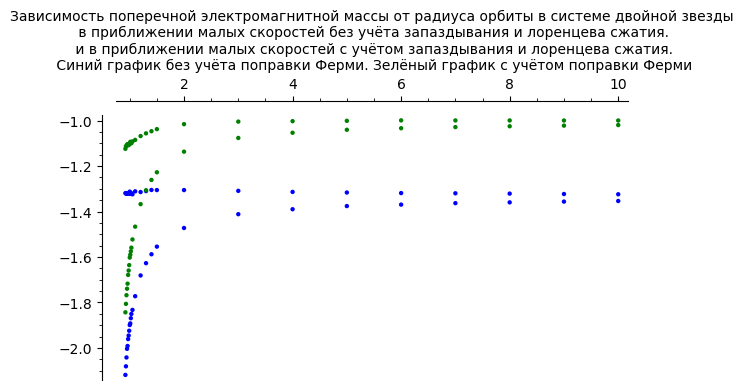

In [18]:
(list_plot(mass_hysteresis_lw_array) + list_plot(mass_hysteresis_fermi_array, color="green")
) .show(title = 
    "Зависимость поперечной электромагнитной массы от радиуса орбиты в системе двойной звезды\n"
    " в приближении малых скоростей без учёта запаздывания и лоренцева сжатия.\n"
    " и в приближении малых скоростей с учётом запаздывания и лоренцева сжатия.\n"
    " Синий график без учёта поправки Ферми. Зелёный график с учётом поправки Ферми")

$^3$ Обычно говорят, что электромагнитная масса равномерно заряженного сферического слоя с общим зарадом $e$ и радиусом $r$ равна $\frac{2}{3} \frac{e^2}{r c^2}$; если же заметить, что электростатическая энергия $u = \frac{1}{2} \frac{e^2}{r}$, то для массы находим как раз $\left(\frac{4}{3}\right) \frac{u}{c^2}$.

$^3$ Обычно говорят, что электромагнитная масса равномерно заряженной сферы с общим зарадом $e$ и радиусом $r$ равна $\frac{8}{5} \frac{e^2}{r c^2}$; если же заметить, что электростатическая энергия $u = \frac{6}{5} \frac{e^2}{r}$, то для массы находим как раз $\left(\frac{4}{3}\right) \frac{u}{c^2}$.